**Autora** : Rafaela Ramos Sarmento

**e-mail**: rafaelaramos.datasci@gmail.com

#  <a name="resumo"> RESUMO </a>
[Voltar ao índice](#indice)

A Base de dados trabalhada é a **'Santander Customer Transaction Prediction' disponível no link:** https://www.kaggle.com/c/santander-customer-transaction-prediction

Essa base de dados envolve um problema de classificação binária, isto é, a partir das features disponíveis, decidir se caso é X ou Y, ou de maneira binária, 0 ou 1.


#  <a name="indice">  Índice </a>

* [Resumo](#resumo)
* [Índice](#indice)
* [Problema a ser analisado](#secao_0)
* [Análise descritiva e exploratória](#secao_1)
* [Random Forest](#secao_2)
* [Regressão Logística](#secao_3)
* [GBDT - XGBOOST](#secao_4)
* [Redes Neurais](#secao_5)
* [Comparação Entre  os Modelos](#secao_6)
* [Conclusão do Desafio](#secao_7) 

#  <a name="secao_0"> Problema a ser analisado </a>
[Voltar ao índice](#indice)

Como a base de dados do **'Santander Customer Transaction Prediction'** tem o seguinte texto guia: 

   * "In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem." *


Como temos um problema de classificação binária, e o próprio desafio sugere que a análise conste como uma previsão de que os clientes do banco realizem uma determinada operação no futuro, dadas as variáveis disponíveis no banco de dados do Santander, podemos formular um problema de negócio em que o banco estará oferecendo para o cliente um investimento de renda fixa do programa “Renda Mais”. Neste caso, os modelos de machine learning tem o objetivo de prever se um dado cliente irá participar do programa ou não.

Assim, as variáveis disponíveis poderiam ser interpretados como informações relacionadas a empréstimos realizados e pagos, pagamentos, idade, renda, situação civil e outras trasações e investimentos no banco.

Portanto, queremos criar um modelo de previsão que forneça o indicativo sobre quais clientes possuem maior probabilidade de fazer parte do programa "Renda Mais", de forma que os clientes classificados positivamente (1) receberão e-mails com propostas e propagandas referentes ao programa de investimento.

Para este caso, observa-se que falsos positivos (FP) não são um problema grave, uma vez que um cliente que seja classificado positivamente mas que não tenha interesse no programa poderá apenas ignorar ou recusar a oferta. Entretanto, o caso de falso negativo (FN) é considerado um problema grave, uma vez que o cliente classificado negativamente mas que tenha interesse em investir não recebera a oferta e, assim, o banco perde um cliente em potencial e não haverá lucros. A métrica de classificação de maior importância é o recall, de forma que maximizando o recall estaremos diminuindo o número de falsos negativos.
O recall é dado pela equação:


$$ recall = \frac{VP}{VP + FN}$$



O problema consta com a variável **ID_code** que é a identificação do cliente, a **target** que é o problema que estamos querendo resolver, isto é, é a variável do tipo classe (binária, 0 ou 1), e teremos um total de **200** features, identificadas como: var_0, var_1, ..., var_199.

Um detalhe é que a base de dados de teste não possui a coluna target, então não seria possível verificar as métricas do nosso modelo utilizando esses dados, portanto, o que será feito é dividir a base de treino em duas: uma efetivamente de treino e outra de validação, de forma a ter uma proporção 70% e 30%, respectivamente.
Além disso, a base de dados já esta bastante limpa, não sendo necessário fazer um trabalho arduo de pré-processamento dos dados.


#  <a name="secao_1"> Análise descritiva e exploratória </a>
[Voltar ao índice](#indice)

Vamos calcular algumas propriedades estatisticas dessa base de dados.

   - Não há valores nulos;
   - Dados em mesmo range de escala;
   - Classes desbalanceadas -> proporção 9 (0) para 1 (1)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import statistics as sts
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split

In [ ]:
#criando funcao para ter informacoes sobre os dados
def show_info(data) :
    print('DATASET SHAPE: ', data.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(data.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(data.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(data.isnull().sum())
  

In [ ]:
def plot_roc_curve(y_real, y_previsao, nome_modelo, color_roc = "pink") :
    rfp, rvp,lim = roc_curve(y_real,  y_previsao)
    # Gráfico da curva roc
    auc = roc_auc_score(y_real, y_previsao)
    plt.plot(rfp, rvp, marker='.', label='%s (AUC = %0.2f)' % (nome_modelo, auc),color=color_roc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title('Curva ROC - %s' % nome_modelo, fontsize=15)
    plt.xlabel('1- Especificidade', fontsize=12)
    plt.ylabel('Sensibilidade', fontsize=12)
    plt.grid(color='w', linestyle='dotted', linewidth=1)
    plt.legend()
    #plt.show()

In [ ]:
def plot_curva_learning(modelo, nome_modelo) :
    results = modelo.evals_result()
    # plot learning curves
    plt.plot(results['validation_0']['logloss'], label='train')
    plt.plot(results['validation_1']['logloss'], label='test')
    plt.title('LogLoss vs n_estimator - %s' %nome_modelo)
    plt.ylabel('LogLoss')
    plt.xlabel('n_estimator')
    plt.grid(color='w', linestyle='dotted', linewidth=1)
    plt.legend()
    plt.show()

In [ ]:
df = pd.read_csv("santander-customer-transaction-prediction/train.csv")
df_train, df_validacao = train_test_split(df, train_size=0.7, shuffle=True)

#df_test = pd.read_csv("santander-customer-transaction-prediction/test.csv")

In [ ]:
#criando os arrays para X {variaveis previsoras} e Y {variavel tipo classe} para treino e teste
Y_train = df_train.iloc[:, 1].values
X_train = df_train.iloc[:, 2:].values
Y_validacao = df_validacao.iloc[:, 1].values 
X_validacao = df_validacao.iloc[:, 2:].values

In [ ]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
70197,train_70197,0,7.5930,-4.4951,11.7194,4.3922,8.8027,-17.6640,6.8718,17.9505,...,5.6948,10.0355,2.3923,5.0582,17.6801,-2.0170,0.8251,9.6314,15.5114,14.2601
50481,train_50481,0,7.8967,-5.6191,13.0385,8.2216,9.8487,-2.3504,4.9904,18.4480,...,-1.3388,6.7010,2.8875,3.5149,18.1092,0.1328,3.3125,8.2643,18.2931,-15.2632
26477,train_26477,1,6.7954,-0.5883,5.8955,3.9075,11.0372,-11.3375,7.4112,12.9902,...,5.0932,4.3161,1.2532,3.7374,23.8799,-3.1827,13.6412,8.9730,12.2996,-16.2891
167332,train_167332,0,13.4323,-0.1844,9.1492,7.0979,10.0791,-14.6293,4.1237,13.3847,...,1.5307,12.5179,2.1119,4.4935,20.5807,1.7595,-0.5109,9.9384,16.3147,-1.3673
62228,train_62228,0,8.9270,-8.0172,8.3204,3.5993,12.4823,3.5828,4.8830,21.2775,...,7.0091,7.2177,5.4472,5.8761,19.2103,-1.3245,-10.3941,7.9709,18.3459,7.4370


In [ ]:
show_info(df_train)

DATASET SHAPE:  (140000, 202) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140000 entries, 70197 to 195347
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 216.8+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

ID_code    140000
target          2
var_0       79761
var_1       89357
var_2       74297
            ...  
var_195     52501
var_196     99647
var_197     37946
var_198     79331
var_199    113623
Length: 202, dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64


In [ ]:
show_info(df_validacao)

DATASET SHAPE:  (60000, 202) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 74306 to 8452
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 92.9+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

ID_code    60000
target         2
var_0      45928
var_1      48670
var_2      44144
           ...  
var_195    36218
var_196    51572
var_197    29011
var_198    45825
var_199    54689
Length: 202, dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64


#### Primeiras observações 

Legenda para entendimento do problema: 
   *  ID_code :  identificação do cliente
   *  target: variável que queremos prever
   *  var_i ; i = 0, 1, ..., 199
   
observa-se que em ambos conjuntos de dados, treino e validacao, não há valores nulos. Também não será necessário fazer processo de cleaning e escalonamento, visto que as variáveis estão sem significado e as ordens de grandeza estão próximas. 

Temos um caso de classes desbalanceadas, sendo as contagens:
  - Treino:
      * classe 0 : 125972 contagens  
      * classe 1 : 14028 contagens
  - Validação:
      * classe 0 : 53930 contagens  
      * classe 1 : 6070 contagens

In [ ]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,...,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000
mean,0.100636,10.685293,-1.636544,10.719682,6.799216,11.076656,-5.081516,5.409367,16.543386,0.286315,...,3.237778,7.436732,1.926656,3.330479,17.996502,-0.141078,2.302753,8.908147,15.865155,-3.317204
std,0.300847,3.037937,4.043152,2.640608,2.042239,1.623227,7.869765,0.866004,3.417761,3.336735,...,4.561830,3.023690,1.478636,3.991352,3.134652,1.430021,5.452793,0.922759,3.006958,10.438259
min,0.000000,0.452800,-15.043400,2.117100,-0.040200,5.074800,-30.681600,2.347300,5.349700,-10.505500,...,-13.454700,-2.691700,-3.814500,-11.783400,8.694400,-5.154700,-14.020400,5.960600,6.299300,-38.852800
25%,0.000000,8.460650,-4.741250,8.734600,5.260100,9.882475,-11.224425,4.768300,13.937975,-2.312200,...,-0.053900,5.157475,0.888400,0.584075,15.629150,-1.168300,-1.948325,8.250900,13.826900,-11.211925
50%,0.000000,10.531700,-1.616300,10.585900,6.827200,11.105100,-4.851100,5.385450,16.458300,0.397050,...,3.202400,7.343900,1.901800,3.387900,17.965500,-0.174250,2.411900,8.889100,15.932650,-2.805050
75%,0.000000,12.761900,1.345400,12.521500,8.325225,12.259100,0.920900,6.003000,19.094100,2.943200,...,6.407300,9.509825,2.948200,6.206125,20.397575,0.831900,6.556200,9.595500,18.052725,4.845775
max,1.000000,20.315000,10.376800,18.635400,13.188300,16.671400,17.128100,8.447700,27.691800,10.151300,...,18.440900,16.716500,7.811100,17.908600,27.597300,4.255700,18.321500,12.000400,26.034600,28.500700


In [ ]:
df_validacao.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.100150,10.667364,-1.606803,10.704714,6.790260,11.082246,-5.027520,5.407972,16.551599,0.279138,...,3.226649,7.442321,1.930598,3.334795,17.987442,-0.144445,2.304694,8.908183,15.883706,-3.348313
std,0.300202,3.044967,4.066037,2.641555,2.045840,1.622976,7.848018,0.868021,3.418832,3.323065,...,4.555493,3.022318,1.477933,3.993644,3.136369,1.427866,5.458090,0.918983,3.020214,10.437501
min,0.000000,0.408400,-14.091000,2.615000,0.043000,5.277800,-32.562600,2.385700,6.465300,-9.476600,...,-14.093300,-2.009400,-3.515900,-10.845500,8.957500,-5.261000,-14.209600,6.232800,6.644800,-38.852800
25%,0.000000,8.440925,-4.737150,8.700075,5.239275,9.884800,-11.148375,4.766600,13.954375,-2.333625,...,-0.070400,5.157400,0.893375,0.587350,15.630950,-1.176000,-1.944150,8.256700,13.835700,-11.203150
50%,0.000000,10.511450,-1.590150,10.567150,6.820400,11.116150,-4.793950,5.384100,16.453650,0.386100,...,3.206200,7.357100,1.900700,3.413750,17.940650,-0.168550,2.403500,8.886300,15.936600,-2.863300
75%,0.000000,12.750025,1.389525,12.505425,8.320900,12.264850,0.932775,6.002925,19.120200,2.927350,...,6.405125,9.519200,2.951400,6.204975,20.393225,0.823900,6.559400,9.588200,18.093300,4.813225
max,1.000000,20.074000,9.511900,19.353000,13.098300,16.085500,17.251600,8.285200,27.597700,9.880900,...,18.342300,16.409400,8.402400,18.281800,27.928800,4.272900,17.684100,11.827700,26.079100,27.531900


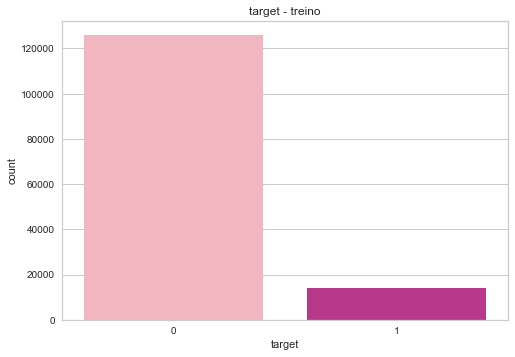

In [ ]:
#verificando a quantidade de cada classe dentro do conjunto de dados de treino
sns.countplot(x=df_train['target'], palette = 'RdPu').set_title('target - treino')
plt.show()

In [ ]:
np.unique(Y_train, return_counts = True)

(array([0, 1]), array([125911,  14089]))

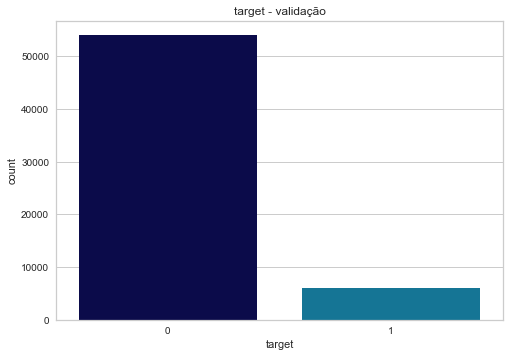

In [ ]:
#verificando a quantidade de cada classe dentro do conjunto de dados de validacao
sns.countplot(x=df_validacao['target'], palette = 'ocean').set_title('target - validação')
plt.show()

In [ ]:
np.unique(Y_validacao, return_counts = True)

(array([0, 1]), array([53991,  6009]))

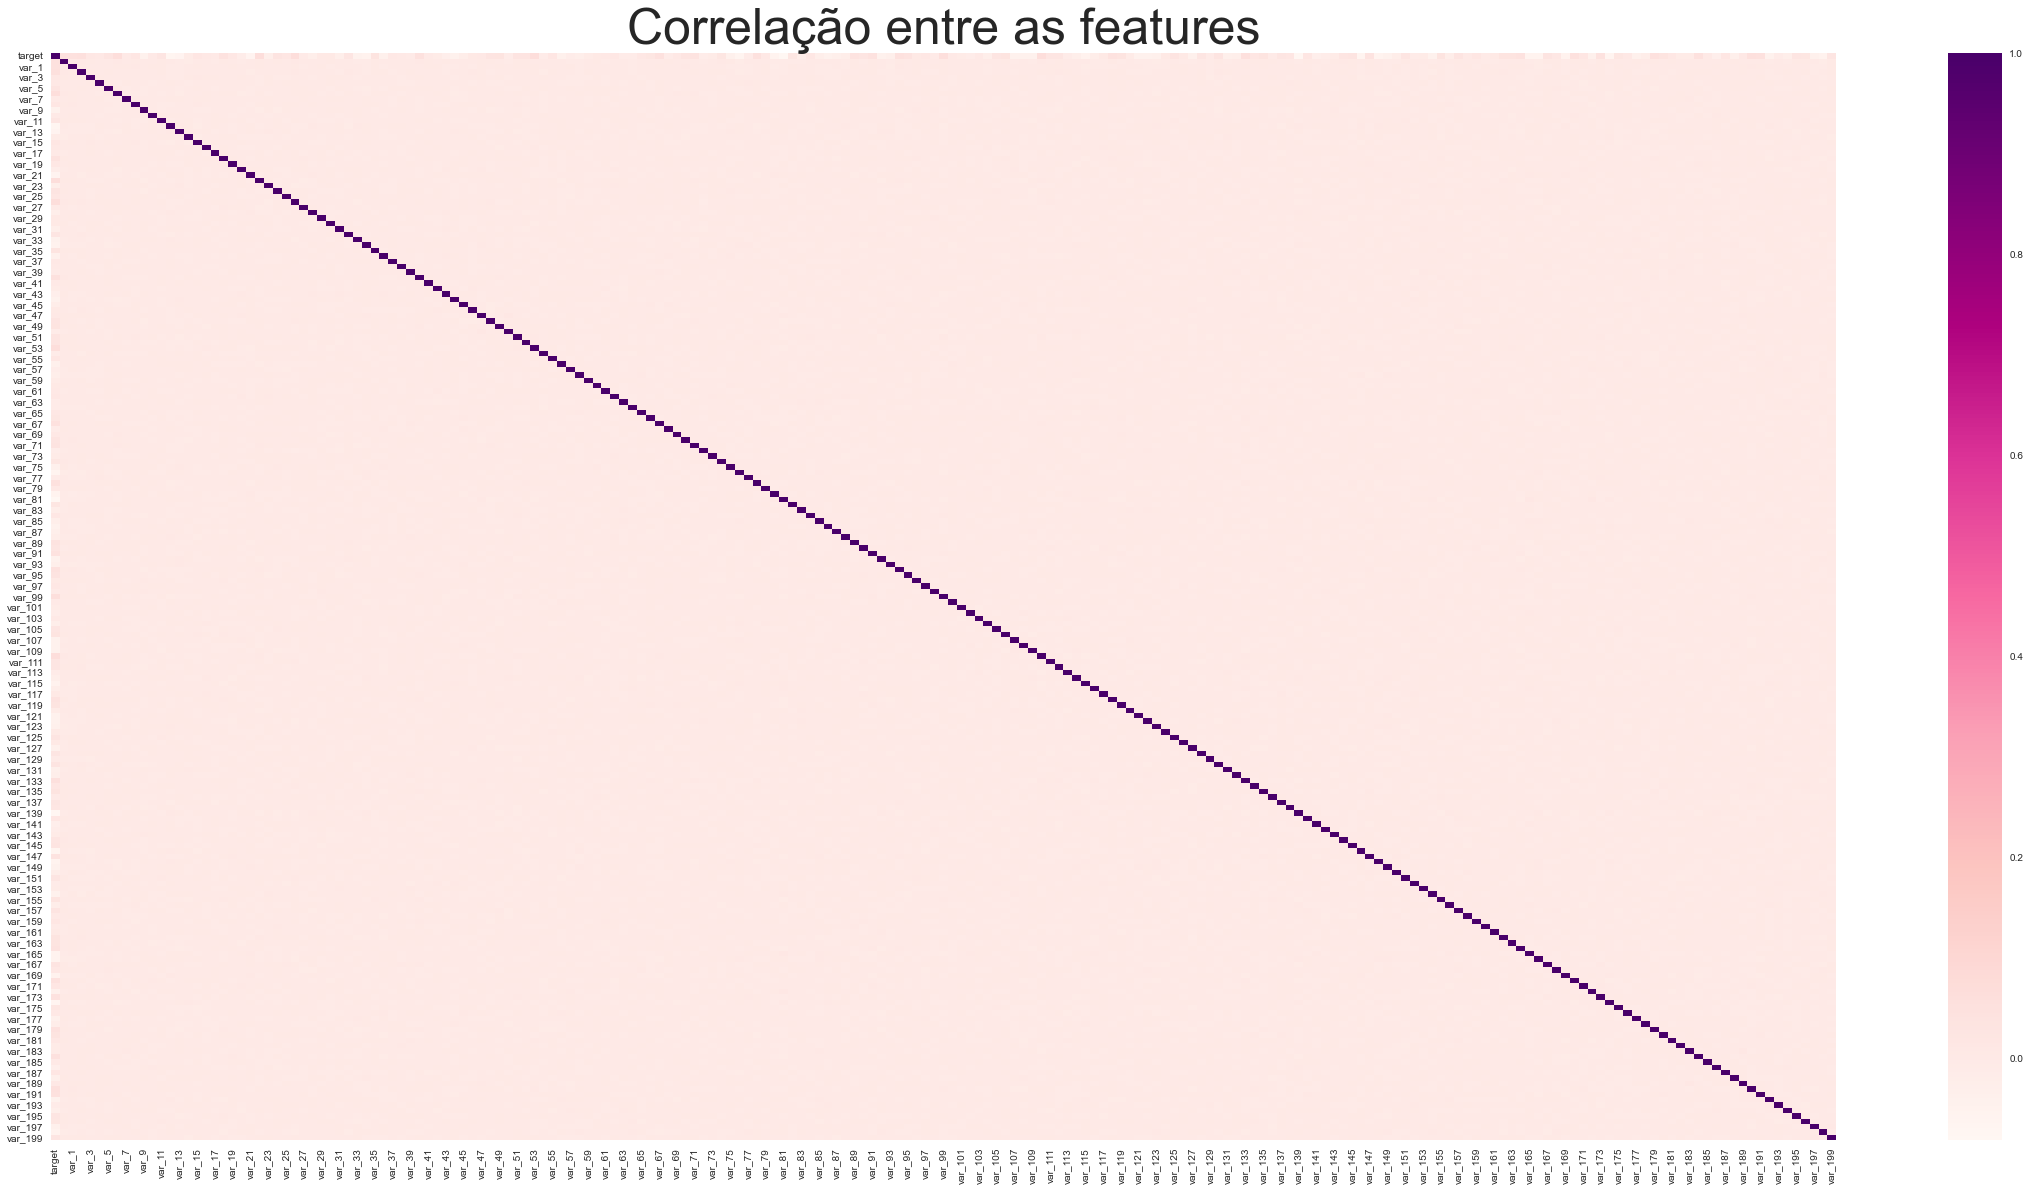

In [ ]:
#calculo da matriz de correlação entre as variáveis do problema
plt.figure(figsize=(40,20)) 
plt.title('Correlação entre as features', size = 50) 
sns.heatmap(df_train.corr(), cmap='RdPu')
plt.show()

A seguir, o calculo matriz de correlacao, verifica quais entradas é maior que 0.5 e faz a contagem. A diagonal sempre vai valer 1, se tiver 201 contagens nao nulas, entao as variaveis nao sao correlacionadas.

In [ ]:
correlacao = df_train.corr()
qtd_correlacao = np.where(abs(correlacao)>0.5, 1, 0)
np.count_nonzero(qtd_correlacao), qtd_correlacao

(201,
 array([[1, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]]))

#  <a name="secao_2"> Random Forest </a>
[Voltar ao índice](#indice)

Vamos iniciar o processo de previsão utilizando um algoritmo mais simples, o Random Forest.

Para este caso, foi testado alguns modelos manualmente e após isso foi utilizado o GridSearchCV() para encontrar o melhor modelo dentro de algumas possibilidades de hiper parâmetros. 

Com o melhor modelo, foi calculado as principais métricas para um caso de classificação, sendo elas a matriz de confusão, precision, recall e a curva ROC. Também foi plotado as 10 features mais importantes para o treino do modelo, essa informação poderia ser utilizada para eliminar features pouco importantes e deixar o treino com um custo computacional menor. Esse ultimo processo não foi feito nessa análise.


Parâmetros utilizados e variados:
   - n_estimator
   - max_depth
   - criterion = 'entropy' (fixo)
   
métrica maximizada: **recall** 

O melhor modelo, utilizando o GridSearchCV() foi construido usando os seguintes parâmetros:
   - n_estimator: 200
   - max_depth: 12

   
Com o recall sendo igual a:
   - Recall Score : 0.7235
   

In [ ]:
!pip install imblearn

In [ ]:
pip install threadpoolctl==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, roc_auc_score
from yellowbrick.classifier import ConfusionMatrix
from imblearn.over_sampling import BorderlineSMOTE 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, RocCurveDisplay, roc_curve

In [ ]:
X_train.shape, Y_train.shape

((140000, 200), (140000,))

In [ ]:
X_validacao.shape, Y_validacao.shape

((60000, 200), (60000,))

In [ ]:
#balanceando os dados, de forma a usar a técnica de oversampling
smote_random_forest = BorderlineSMOTE(sampling_strategy='minority')
X_over_train, Y_over_train = smote_random_forest.fit_resample(X_train, Y_train)
X_over_validacao, Y_over_validacao = smote_random_forest.fit_resample(X_validacao, Y_validacao)

In [ ]:
np.unique(Y_over_train, return_counts=True)

(array([0, 1]), array([125911, 125911]))

In [ ]:
np.unique(Y_over_validacao, return_counts=True)

(array([0, 1]), array([53991, 53991]))

In [ ]:
#inciando o treinamento com a Random Forest, usando a metrica para hierarquia das features
#a minimizacao da entropia (maximizacao do ganho de informacao)
random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=12, verbose=1,random_state = 0)
random_forest.fit(X_over_train, Y_over_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 21.1min finished


RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200,
                       random_state=0, verbose=1)

In [ ]:
previsoes_random_forest = random_forest.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_random_forest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.0s finished


0.7234909521957363

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.1s finished


0.7960400807541997

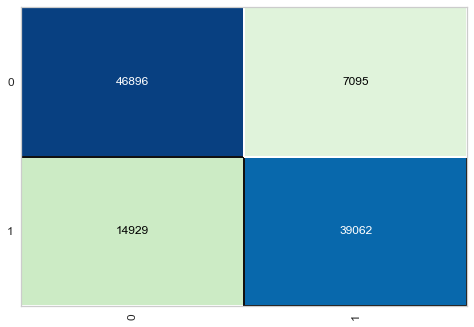

In [ ]:
#calculo de algumas métricas de classificação: matriz de confusao
matriz_confusao_random_forest = ConfusionMatrix(random_forest, cmap='GnBu')
matriz_confusao_random_forest.fit(X_over_train, Y_over_train)
matriz_confusao_random_forest.score(X_over_validacao, Y_over_validacao)

In [ ]:
#printa as métricas de classificação
print(classification_report(Y_over_validacao, previsoes_random_forest))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81     53991
           1       0.85      0.72      0.78     53991

    accuracy                           0.80    107982
   macro avg       0.80      0.80      0.79    107982
weighted avg       0.80      0.80      0.79    107982



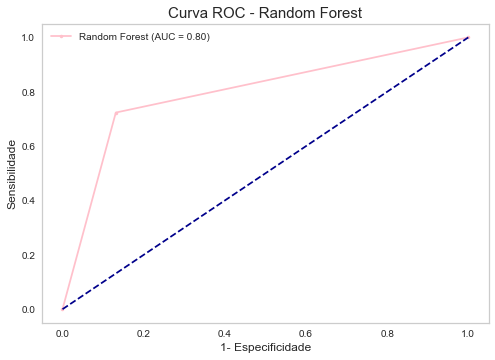

In [ ]:
#RocCurveDisplay.from_estimator(random_forest, X_over_validacao, Y_over_validacao, name = 'Random Forest')
roc_random_forest = plot_roc_curve(Y_over_validacao, previsoes_random_forest, 'Random Forest')
plt.show()

<AxesSubplot:>

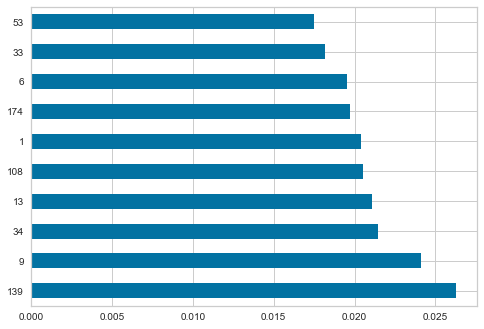

In [ ]:
#plotando o ranking de importancia das features utilizadas para treinar o meu modelo
feat_importances = pd.Series(random_forest.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
#tunando os hyperparametros com o gridsearch:
parametros = {'criterion': ['entropy'], 
              'n_estimators': [50, 100, 200],
              'max_depth': [6, 9, 12],
               'random_state': [0]}  

grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros, scoring='recall', cv=2)
grid_rf.fit(X_over_train, Y_over_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [6, 9, 12],
                         'n_estimators': [50, 100, 200], 'random_state': [0]},
             scoring='recall')

In [ ]:
print('Melhor modelo: ' + str(grid_rf.best_estimator_))
print('Best Score: ' + str(grid_rf.best_score_))

Melhor modelo: RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200,
                       random_state=0)
Best Score: 0.9100629240086487


#  <a name="secao_3"> Regressão Logística </a>
[Voltar ao índice](#indice)

Tentando um modelo mais simples para verificar como os dados se comportam. Para isso, será utilizado a regressão logística.

Parâmetros utilizados e variados:
   - max_iter
   - solver
   
métrica maximizada: recall 

O melhor modelo, utilizando o GridSearchCV() foi construido usando os seguintes parâmetros:
   - max_iter: 1500
   - solver: 'lbfgs'
   
Com o recall sendo igual a:
   - recall: 0.8037

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic_regression = LogisticRegression(max_iter=1500, random_state = 0)
logistic_regression.fit(X_over_train, Y_over_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1500, random_state=0)

In [ ]:
#logistic_regression.coef_

In [ ]:
previsoes_logistic = logistic_regression.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_logistic)

0.8037635902280009

0.8038098942416328

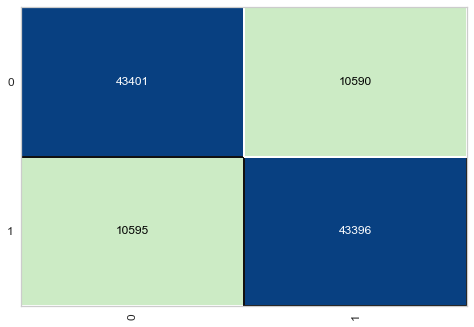

In [ ]:
matriz_confusao_logistic = ConfusionMatrix(logistic_regression, cmap='GnBu')
matriz_confusao_logistic.fit(X_over_train, Y_over_train)
matriz_confusao_logistic.score(X_over_validacao, Y_over_validacao)

In [ ]:
print(classification_report(Y_over_validacao, previsoes_logistic))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     53991
           1       0.80      0.80      0.80     53991

    accuracy                           0.80    107982
   macro avg       0.80      0.80      0.80    107982
weighted avg       0.80      0.80      0.80    107982



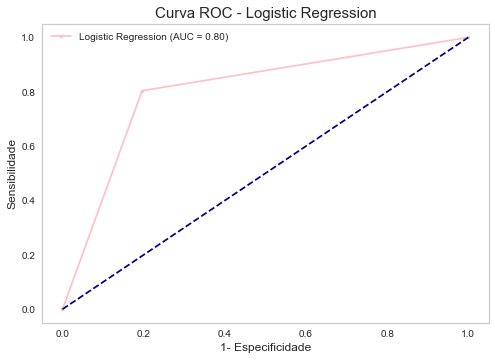

In [ ]:
roc_logistic = plot_roc_curve(Y_over_validacao, previsoes_logistic, 'Logistic Regression')

In [ ]:
#tunando os hiperparametros da logistic regression com o GridSearchCV()
parametros_logistic = {'max_iter': [100, 300, 500, 1000, 1500],
                   'solver': ['lbfgs', 'saga'],
               }  

grid_logistic= GridSearchCV(estimator=LogisticRegression(), param_grid=parametros_logistic, cv=2, scoring='recall', verbose=0)
grid_logistic.fit(X_over_train, Y_over_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 300, 500, 1000, 1500],
                         'solver': ['lbfgs', 'saga']},
             scoring='recall')

In [ ]:
print('Melhor modelo: ' + str(grid_logistic.best_estimator_))
print('Best Score: ' + str(grid_logistic.best_score_))

Melhor modelo: LogisticRegression(max_iter=1500)
Best Score: 0.822676229584365


#  <a name="secao_4"> GBDT - XGBOOST </a>
[Voltar ao índice](#indice)

Utilizando a GBDT, um algoritmo mais avançado, em que teremos um ensemble de decisions trees trabalhando de forma sequencial. A GBDT aqui é implementada pela biblioteca XGBoost.

Parâmetros utilizados e variados:
   - n_estimator
   - max_depth
   - learning_rate

métrica maximizada: recall 

O melhor modelo, utilizando o GridSearchCV() foi construido usando os seguintes parâmetros:
   - n_estimator: 200
   - max_depth: 9
   - learning_rate: 0.3 
   
Com o recall sendo igual a:
   - recall: 0.7417

Entretanto, este modelo overfitou, assim, os parâmetros foram atualizados e adicionou-se um parâmetro de regularização (L2 - reg_gamma). De forma, que obteve-se o resultado:
   - n_estimator: 500
   - max_depth: 4
   - learning_rate: 0.1 
   
Com o recall sendo igual a:
   - recall: 0.8284

In [ ]:
import xgboost as xgb
import xgboost as get_score
from sklearn.metrics import log_loss

In [ ]:
#treinando modelo com os dados já balanceados pela etapa do random forest
GBDT = xgb.XGBClassifier(n_estimators=500, max_depth=4, learning_rate=0.1,random_state=0, reg_lambda=0.1)
GBDT.fit(X_over_train, Y_over_train, eval_metric='logloss', eval_set=[(X_over_train, Y_over_train), (X_over_validacao, Y_over_validacao)])

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68671	validation_1-logloss:0.68794
[1]	validation_0-logloss:0.68066	validation_1-logloss:0.68250
[2]	validation_0-logloss:0.67515	validation_1-logloss:0.67745
[3]	validation_0-logloss:0.66981	validation_1-logloss:0.67254
[4]	validation_0-logloss:0.66450	validation_1-logloss:0.66773
[5]	validation_0-logloss:0.65940	validation_1-logloss:0.66315
[6]	validation_0-logloss:0.65455	validation_1-logloss:0.65895
[7]	validation_0-logloss:0.64976	validation_1-logloss:0.65468
[8]	validation_0-logloss:0.64507	validation_1-logloss:0.65065
[9]	validation_0-logloss:0.64058	validation_1-logloss:0.64659
[10]	validation_0-logloss:0.63626	validation_1-logloss:0.64271
[11]	validation_0-logloss:0.63185	validation_1-logloss:0.63868
[12]	validation_0-logloss:0.62769	validation_1-logloss:0.63499
[13]	validation_0-logloss:0.62353	validation_1-logloss:0.63112
[14]	validation_0-logloss:0.61947	validation_1-logloss:0.62727
[15]	validation_0-logloss:0.61559	validation_1-logloss:0.62375
[1

[130]	validation_0-logloss:0.39114	validation_1-logloss:0.42910
[131]	validation_0-logloss:0.39021	validation_1-logloss:0.42836
[132]	validation_0-logloss:0.38922	validation_1-logloss:0.42759
[133]	validation_0-logloss:0.38826	validation_1-logloss:0.42678
[134]	validation_0-logloss:0.38726	validation_1-logloss:0.42588
[135]	validation_0-logloss:0.38627	validation_1-logloss:0.42505
[136]	validation_0-logloss:0.38529	validation_1-logloss:0.42435
[137]	validation_0-logloss:0.38435	validation_1-logloss:0.42353
[138]	validation_0-logloss:0.38333	validation_1-logloss:0.42265
[139]	validation_0-logloss:0.38237	validation_1-logloss:0.42185
[140]	validation_0-logloss:0.38140	validation_1-logloss:0.42120
[141]	validation_0-logloss:0.38041	validation_1-logloss:0.42040
[142]	validation_0-logloss:0.37940	validation_1-logloss:0.41963
[143]	validation_0-logloss:0.37850	validation_1-logloss:0.41893
[144]	validation_0-logloss:0.37761	validation_1-logloss:0.41816
[145]	validation_0-logloss:0.37672	valid

[259]	validation_0-logloss:0.30273	validation_1-logloss:0.36114
[260]	validation_0-logloss:0.30223	validation_1-logloss:0.36083
[261]	validation_0-logloss:0.30181	validation_1-logloss:0.36050
[262]	validation_0-logloss:0.30138	validation_1-logloss:0.36013
[263]	validation_0-logloss:0.30091	validation_1-logloss:0.35975
[264]	validation_0-logloss:0.30047	validation_1-logloss:0.35942
[265]	validation_0-logloss:0.29997	validation_1-logloss:0.35907
[266]	validation_0-logloss:0.29949	validation_1-logloss:0.35874
[267]	validation_0-logloss:0.29910	validation_1-logloss:0.35841
[268]	validation_0-logloss:0.29864	validation_1-logloss:0.35811
[269]	validation_0-logloss:0.29817	validation_1-logloss:0.35783
[270]	validation_0-logloss:0.29774	validation_1-logloss:0.35751
[271]	validation_0-logloss:0.29731	validation_1-logloss:0.35719
[272]	validation_0-logloss:0.29683	validation_1-logloss:0.35682
[273]	validation_0-logloss:0.29634	validation_1-logloss:0.35656
[274]	validation_0-logloss:0.29592	valid

[388]	validation_0-logloss:0.25629	validation_1-logloss:0.33090
[389]	validation_0-logloss:0.25602	validation_1-logloss:0.33079
[390]	validation_0-logloss:0.25574	validation_1-logloss:0.33063
[391]	validation_0-logloss:0.25545	validation_1-logloss:0.33049
[392]	validation_0-logloss:0.25514	validation_1-logloss:0.33027
[393]	validation_0-logloss:0.25490	validation_1-logloss:0.33011
[394]	validation_0-logloss:0.25462	validation_1-logloss:0.32992
[395]	validation_0-logloss:0.25438	validation_1-logloss:0.32979
[396]	validation_0-logloss:0.25412	validation_1-logloss:0.32965
[397]	validation_0-logloss:0.25384	validation_1-logloss:0.32946
[398]	validation_0-logloss:0.25355	validation_1-logloss:0.32931
[399]	validation_0-logloss:0.25328	validation_1-logloss:0.32915
[400]	validation_0-logloss:0.25302	validation_1-logloss:0.32901
[401]	validation_0-logloss:0.25276	validation_1-logloss:0.32885
[402]	validation_0-logloss:0.25247	validation_1-logloss:0.32874
[403]	validation_0-logloss:0.25219	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
previsoes_gbdt = GBDT.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_gbdt)

0.8283973254801726

0.8752477264729307

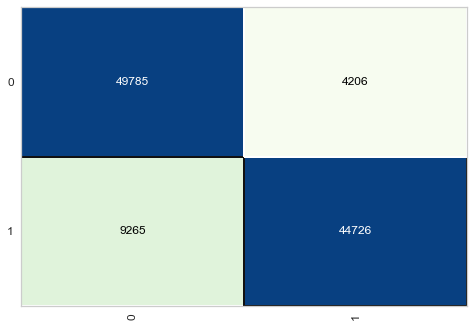

In [ ]:
#calculo de algumas métricas de classificação: matriz de confusao
matriz_confusao_gbdt = ConfusionMatrix(GBDT, cmap='GnBu')
matriz_confusao_gbdt.fit(X_over_train, Y_over_train)
matriz_confusao_gbdt.score(X_over_validacao, Y_over_validacao)

In [ ]:
#printa as métricas de classificação
print(classification_report(Y_over_validacao, previsoes_gbdt))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     53991
           1       0.91      0.83      0.87     53991

    accuracy                           0.88    107982
   macro avg       0.88      0.88      0.87    107982
weighted avg       0.88      0.88      0.87    107982



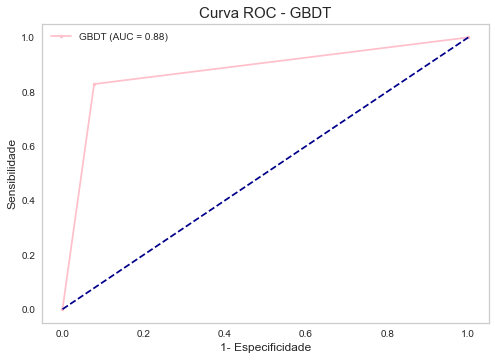

In [ ]:
roc_gbdt = plot_roc_curve(Y_over_validacao, previsoes_gbdt, 'GBDT')

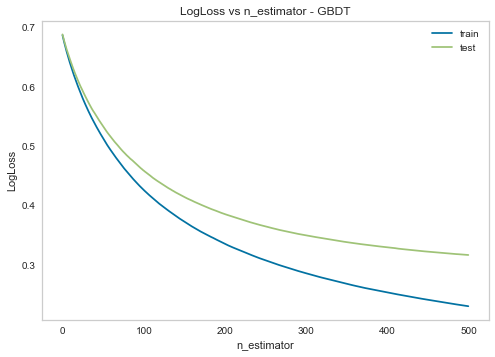

In [ ]:
logloss_gbdt = plot_curva_learning(GBDT, 'GBDT')

<AxesSubplot:>

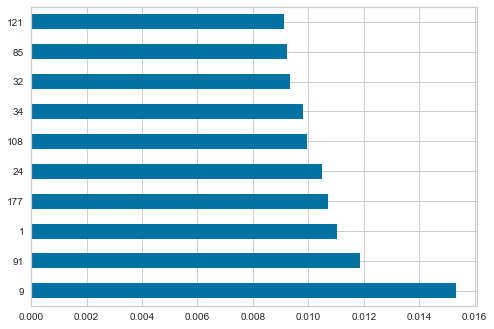

In [ ]:
feat_importances = pd.Series(GBDT.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
#tunando os hiperparametros da GBDT com o GridSearchCV()
parametros_gbdt = {'n_estimators': [100, 150, 200],
              'max_depth': [3, 6, 9],
                   'learning_rate': [0.1],
               }  

grid_gbdt = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=parametros_gbdt, cv=2, scoring='recall', verbose=0)
grid_gbdt.fit(X_over_train, Y_over_train)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:59:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:02:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:05:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:09:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:01:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:19:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:41:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:30:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:39:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:27:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:16:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:46:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             param_grid={'max_depth': [3, 5, 9],
                         'n_estimators': [100, 150, 200]},
             scoring='recall')

In [ ]:
print('Melhor modelo: ' + str(grid_gbdt.best_estimator_))
print('Best Score: ' + str(grid_gbdt.best_score_))

Melhor modelo: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best Score: 0.9375585850643632


#  <a name="secao_5"> Redes Neurais </a>
[Voltar ao índice](#indice)

Para a aplicação de redes neurais para resolver o problema, será utilizado uma rede neural simples, implementada pelo sklearn, a MLPClassifier()   (MultiLayer Perceptron).

Parâmetros utilizados e variados:
   - max_iter (epocas)
   - activation = 'logistic'
   - hidden_layer_sizes 
   
métrica maximizada: recall 

O melhor modelo encontrado:
   - max_iter (epocas) = 300 (efetivos=78)
   - hidden_layer_sizes = (100, 50, 25, 13,7) 
   
Com o recall sendo igual a:
   - recall: 0.7827
   

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# 200 (neuronios entrada) -> 100 (1 camada oculta com 100 neuronios) -> 1 (neuronio saida)
rede_neural = MLPClassifier(max_iter=300, verbose=True, hidden_layer_sizes = (100, 50, 25, 13,7), activation='logistic', random_state=0)
rede_neural.fit(X_over_train, Y_over_train)

Iteration 1, loss = 0.53542001
Iteration 2, loss = 0.44677791
Iteration 3, loss = 0.42955372
Iteration 4, loss = 0.41790353
Iteration 5, loss = 0.40852673
Iteration 6, loss = 0.40211572
Iteration 7, loss = 0.39840953
Iteration 8, loss = 0.39520447
Iteration 9, loss = 0.39263193
Iteration 10, loss = 0.39208268
Iteration 11, loss = 0.38861466
Iteration 12, loss = 0.38704760
Iteration 13, loss = 0.38559195
Iteration 14, loss = 0.38456952
Iteration 15, loss = 0.38319740
Iteration 16, loss = 0.38312705
Iteration 17, loss = 0.38079588
Iteration 18, loss = 0.38012633
Iteration 19, loss = 0.37970658
Iteration 20, loss = 0.37961185
Iteration 21, loss = 0.37846996
Iteration 22, loss = 0.37689962
Iteration 23, loss = 0.37642540
Iteration 24, loss = 0.37599985
Iteration 25, loss = 0.37583992
Iteration 26, loss = 0.37522522
Iteration 27, loss = 0.37379883
Iteration 28, loss = 0.37466082
Iteration 29, loss = 0.37408275
Iteration 30, loss = 0.37262701
Iteration 31, loss = 0.37311305
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50, 25, 13, 7),
              max_iter=300, random_state=0, verbose=True)

In [ ]:
previsoes_rn = rede_neural.predict(X_over_validacao)
recall_score(Y_over_validacao, previsoes_rn)

0.7826860032227594

0.7909373784519642

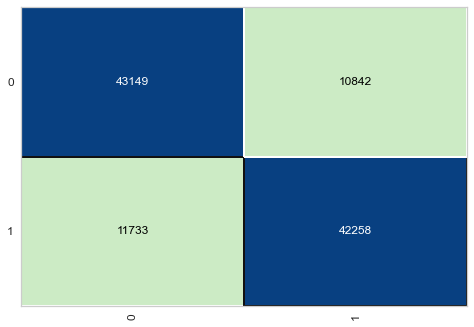

In [ ]:
matriz_confusao_rn = ConfusionMatrix(rede_neural, cmap='GnBu')
matriz_confusao_rn.fit(X_over_train, Y_over_train)
matriz_confusao_rn.score(X_over_validacao, Y_over_validacao)

In [ ]:
print(classification_report(Y_over_validacao, previsoes_rn))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79     53991
           1       0.80      0.78      0.79     53991

    accuracy                           0.79    107982
   macro avg       0.79      0.79      0.79    107982
weighted avg       0.79      0.79      0.79    107982



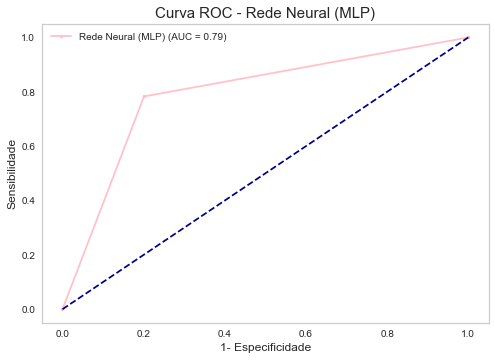

In [ ]:
roc_redeneural = plot_roc_curve(Y_over_validacao, previsoes_rn, 'Rede Neural (MLP)')

#  <a name="secao_6"> Comparação Entre os Modelos </a>
[Voltar ao índice](#indice)   

Os modelos foram avaliados segundo a métrica **recall**. De forma que, resumidamente, obtivemos os seguintes resultados:

   -  **Random Forest**: 0.72
   - **Regressão Logistica**: 0.80
   - **GBDT**: 0.82
   - **Rede Neural**: 0.78    
   
Com isso, olhando apenas para o recall, a GBDT demonstrou possuir uma melhor performance, apesar de ter apresentado overfiting com o modelo retornado pelo GridSearchCV(). 
A GBDT também apresenta uma melhor curva ROC, estando mais localizada ao canto superior esquerdo do gráfico, sua AUC foi igual a 0.88.

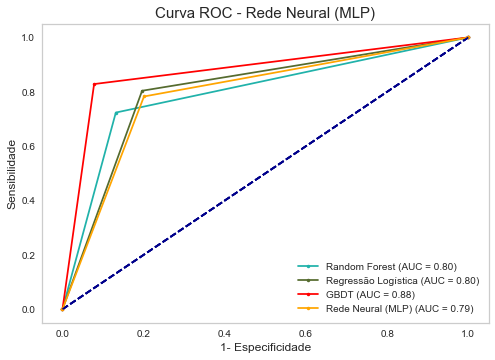

In [ ]:
plot_roc_curve(Y_over_validacao, previsoes_random_forest, 'Random Forest', 'lightseagreen')
plot_roc_curve(Y_over_validacao, previsoes_logistic, 'Regressão Logística', 'darkolivegreen')
plot_roc_curve(Y_over_validacao, previsoes_gbdt, 'GBDT', 'red')
plot_roc_curve(Y_over_validacao, previsoes_rn, 'Rede Neural (MLP)', 'orange')
plt.show()

#  <a name="secao_7"> Conclusão do desafio </a>
[Voltar ao índice](#indice)

Como o problema proposto no desafio era bastante aberto, foi escolhido uma abordagem exploratória de modelos de Machine Learning para realizar a previsão de uma possível tranasação envolvendo clientes do banco Santander. O problema envolveu um banco de dados do Kaggle e consistiu de um problema de classificação binária, também preferido pelo enunciado do desafio. 

O pré processamento foi curto uma vez que o dados eram bastante limpos e comportados, bastando apenas de um processo de balanceamento, no qual se usou uma técnica de oversampling. A análise preditiva de classificação buscou testar desde os modelos mais simples, como a Regressão Logística, até os mais sofisticados, como o GBDT. O que se observou foi que apesar do nivel de complexidade entre estas duas técnicas ser bastante diferente, ambas retornaram um valor de recall bastante próximos, de forma que o custo-benefício tende a Regressão Logística. 

O pior valor encontrado foi referente ao Random Forest.

A verificação de overfitting foi realizada apenas para o GBDT, mas poderia ter sido feito para todos os demais modelos. 